## Note

* Incorporate the information from the backward passes into the forward pass, to avoid making similar mistakes


## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import Normalizer, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import datetime
import os
import pickle

import sys
sys.path.append("../")
sys.path.append("../ext/OSTrack/")

from src.util import load_rects, draw_rect, HOTDataset, HOTDatasetMultiCam, save_rects
from src.eval import eval_results, eval_results_v2
from src.tracker import OSTrackWrapper, clip_box
from src.HyperTools import overlap_ratio

In [3]:
device = 'cuda'

## Data

In [4]:
dataset_type = "training"
dataset_path = f"/scratch/datasets/hot_2023/{dataset_type}"
dataset = HOTDatasetMultiCam(dataset_path)
scene_names = {}
for i in range(len(dataset)):
    name = dataset[i].name
    if name in scene_names:
        scene_names[name].append(i)
    else:
        scene_names[name] = [i]

scene_groups = list(scene_names.values())

scenes = np.arange(len(dataset))
rng = np.random.default_rng(seed = 15)
rng.shuffle(scene_groups)
train_n = int(len(scene_groups) * 0.9)
train_scenes = np.concatenate(scene_groups[:train_n])
test_scenes = np.concatenate(scene_groups[train_n:])
print("train / test split:", len(train_scenes), len(test_scenes))
test_scenes


val_dataset = HOTDatasetMultiCam("/scratch/datasets/hot_2023/validation")
val_scenes = np.arange(len(val_dataset))

train / test split: 96 14


## Tracking experiments

In [5]:
from src.util import load_rects, draw_rect, HOTDataset, HOTDatasetMultiCam, save_rects
from src.eval import eval_results, eval_results_v2
from src.tracker import OSTrackWrapper, clip_box
from src.HyperTools import overlap_ratio

from tqdm.notebook import trange, tqdm
from torchdata.datapipes.iter import Prefetcher

from dataclasses import dataclass

@dataclass
class Track:
    bboxes: np.ndarray
    scores: np.ndarray 
    
    def __len__(self):
        return len(self.bboxes)

class ImageLoaderRanged:
    
    def __init__(self, image_loader, start, end, inc):
        self.image_loader = image_loader
        self.start = start
        self.end = end
        self.inc = inc
        
    def __len__(self):
        return (self.end - self.start) * self.inc

    def __getitem__(self, i):
        if i >= len(self):
            raise IndexError            
        frame_id = self.start + i * self.inc
        return frame_id, self.image_loader[frame_id]

def get_distractions(bbox, prev_merged, score, tracks, frame_id, inc, start_frame_id, start_bbox, debug=False):
    # the track is going in the other direction
    if len(tracks) == 0:
        return []
    merged = []
    distractions = []
    for i,t in enumerate(tracks):
        tbbox = t.bboxes[frame_id]
        iou = overlap_ratio(bbox.reshape(-1,4), tbbox.reshape(-1,4))
        original_iou = overlap_ratio(
            start_bbox.reshape(-1,4),
            t.bboxes[start_frame_id].reshape(-1,4))[0]
        # calculate how well is the tbbox connected to other boxes in it's track
        prev_frame_id = frame_id - inc
        tfit = min(
            t.scores[frame_id], # current score
            t.scores[prev_frame_id]) # previous score
        if iou > 0.8:
            if score > 0.6 or i in prev_merged:
                continue
            elif tfit > 1.1 * score and original_iou < 0.2:
#                 if debug:
#                     print("iou, tfit, score, original_iou", iou, tfit, score, original_iou)
                distractions.append(i)
    return distractions

def run_ostrack(
    ostrack: OSTrackWrapper,
    frames, init_bbox, start, end,
    known_tracks, debug=False
):
    if end > start:
        desc = "forward"
        known_tracks = known_tracks["backward"]
        inc = 1
    else:
        desc = "backward"
        inc = -1
        known_tracks = known_tracks["forward"]
        
    frames_range = ImageLoaderRanged(frames, start, end, inc)
    
    for i, (frame_id, frame) in enumerate(tqdm(Prefetcher(frames_range), desc=desc)):
        if i == 0:
            h,w = frame.shape[:2]
            init_bbox = np.array(clip_box(init_bbox, h, w, margin=5))
            bbox = init_bbox
            ostrack.initialize(frame, bbox)
            track = [bbox]
            track_scores = [1.0]
            if debug:
                init_frame = frame.copy()
            merged = []
        else:
            bbox = np.array(clip_box(bbox, h, w, margin=5))
            candidates, scores, _ = ostrack.track(frame, bbox, 0)
            candidates = candidates.numpy(force=True)
            n_pred = len(candidates)
            scores = scores.numpy(force=True).flatten()
            if len(known_tracks) > 0:
                candidates = np.concatenate((candidates, [t.bboxes[frame_id] for t in known_tracks]))
                scores = np.concatenate((scores, np.full(len(known_tracks), 0.2)))
            for j, (c, s) in enumerate(zip(candidates, scores)):
                distr = get_distractions(c, merged, s, known_tracks, frame_id, inc, start, init_bbox, debug)
                if len(distr) > 0:
                    scores[j] = 0
                    distr_id = distr[0]
#                     if debug:
#                         print("frame id", frame_id)
#                         print(f"distractor from track {j}")
#                         fig, axs = plt.subplots(1,2)
#                         init_frame_copy = draw_rect(init_frame.copy(), init_bbox, color=(0,255,0))
#                         init_frame_copy = draw_rect(init_frame_copy, known_tracks[distr_id].bboxes[start], color=(255,0,0))
#                         axs[0].imshow(init_frame_copy)
#                         frame_copy = draw_rect(frame.copy(), c)
#                         axs[1].imshow(frame_copy)
#                         plt.show()
                        
            j = np.argmax(scores)
            if scores[j] > 0:
                bbox, score = candidates[j], scores[j]
                merged = []
                for k,t in enumerate(known_tracks):
                    if overlap_ratio(t.bboxes[frame_id].reshape(-1,4), bbox.reshape(-1,4)) > 0.8:
                        merged.append(k)
            else:
                bbox, score = bbox, 0
                merged = []
            track.append(bbox)
            track_scores.append(score)
    return Track(np.array(track, dtype=int), np.array(track_scores))

ostrack = OSTrackWrapper(
    use_hann=True,
    candidate_bbox_threshold=0.7,
    nms_iou_thresh=0.7,
    max_candidates=3
)

test config:  {'MODEL': {'PRETRAIN_FILE': 'mae_pretrain_vit_base.pth', 'EXTRA_MERGER': False, 'RETURN_INTER': False, 'RETURN_STAGES': [], 'BACKBONE': {'TYPE': 'vit_base_patch16_224_ce', 'STRIDE': 16, 'MID_PE': False, 'SEP_SEG': False, 'CAT_MODE': 'direct', 'MERGE_LAYER': 0, 'ADD_CLS_TOKEN': False, 'CLS_TOKEN_USE_MODE': 'ignore', 'CE_LOC': [3, 6, 9], 'CE_KEEP_RATIO': [0.7, 0.7, 0.7], 'CE_TEMPLATE_RANGE': 'CTR_POINT'}, 'HEAD': {'TYPE': 'CENTER', 'NUM_CHANNELS': 256}}, 'TRAIN': {'LR': 0.0004, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 300, 'LR_DROP_EPOCH': 240, 'BATCH_SIZE': 32, 'NUM_WORKER': 10, 'OPTIMIZER': 'ADAMW', 'BACKBONE_MULTIPLIER': 0.1, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'FREEZE_LAYERS': [0], 'PRINT_INTERVAL': 50, 'VAL_EPOCH_INTERVAL': 20, 'GRAD_CLIP_NORM': 0.1, 'AMP': False, 'CE_START_EPOCH': 20, 'CE_WARM_EPOCH': 80, 'DROP_PATH_RATE': 0.1, 'SCHEDULER': {'TYPE': 'step', 'DECAY_RATE': 0.1}}, 'DATA': {'SAMPLER_MODE': 'causal', 'MEAN': [0.485, 0.456, 0.406], 'STD': [0.229, 0.224, 0.225], '

In [6]:
def backward_forward(ostrack: OSTrackWrapper, frames, bbox_init, scene, debug=False, iou_thrsh=0.2, maxiter=3):

    if debug:
        out_dir = f"../outputs/forward_backward-neighbour/training/{scene.camera_type}/{scene.name}"
        os.makedirs(out_dir, exist_ok=True)
    niter = 0
    start = 0
    end = len(frames)
    tracks = {"forward": [], "backward": []}
    dbg_backward = None
    while start + 1 < end and niter < maxiter:
        niter += 1
        # run forward
        forward = run_ostrack(ostrack, frames, bbox_init, start, end, tracks, debug)
        if len(tracks["forward"]) > 0:
            # pad forward pass with the previous one
            forward.bboxes = np.concatenate((tracks["forward"][-1].bboxes[:start], forward.bboxes))
            forward.scores = np.concatenate((np.ones(start), forward.scores))
        tracks["forward"].append(forward)
        if debug:
            save_rects(os.path.join(out_dir, f"forward_{niter}.txt"), forward.bboxes)
            
        if len(forward) != len(frames):
            print(len(forward), len(frames))
            assert False
        
        # bisect until backtracking is consistent
        consistent = False
        _start = start
        _end = end
        _backtracking_runs = 0
        while not consistent and niter < maxiter:
            _backtracking_runs += 1
            if debug:
                print("consistency check on:", _start, _end)
            backward = run_ostrack(
                ostrack, frames, forward.bboxes[_end-1], _end - 1, _start - 1, tracks, debug)
            backward.bboxes = backward.bboxes[::-1] # reverse
            backward.scores = backward.scores[::-1] # reverse
            # pad backward
            backward.bboxes = np.concatenate((
                np.zeros_like(forward.bboxes[:_start]),
                backward.bboxes,
                forward.bboxes[_end:]
            ))
            backward.scores = np.concatenate((
                np.zeros_like(forward.scores[:_start]),
                backward.scores,
                forward.scores[_end:]
            ))
            if len(backward) != len(frames) or len(backward.bboxes) != len(backward.scores):
                print(len(forward), len(frames), len(backward), len(backward.bboxes), len(backward.scores))
                assert False
            tracks["backward"].append(backward)
            if dbg_backward is None:
                dbg_backward = backward.bboxes.copy()
                if debug:
                    save_rects(os.path.join(out_dir, f"backward_0.txt"), dbg_backward)
            
            iou = overlap_ratio(forward.bboxes[_start:_end], backward.bboxes[_start:_end])
            if debug:
                plt.plot(np.arange(_start, _end), iou, label=str(_backtracking_runs))
            idx = np.argwhere(iou < iou_thrsh) # inconsistency check
            idx += _start
            if len(idx) == 0:
                consistent = True
                continue
            last_consistent = np.max(idx)
            _end = (last_consistent - _start) // 2
#             _end = last_consistent - 1
            if _start + 1 >= _end:
                break

        if not consistent:
            if debug:
                print("failure to find consistent backtracking")
            break
        else:
            if debug:
                print("success, consistent range: ", _start, _end)
            dbg_backward[_start:_end] = backward.bboxes[_start:_end]
            if debug:
                save_rects(os.path.join(out_dir, f"backward_{niter}.txt"), dbg_backward)
            start = _end - 1
            bbox_init = forward.bboxes[start]
    
        if debug:
            plt.ylim(0,1)
            plt.legend()
            plt.show()
    return tracks["forward"][-1].bboxes

In [7]:
version = "v1"

for scene in scenes:
    print("scene id", scene)
    scene = dataset[scene]
    print("scene name", scene.name)
    
    output_dir = f"../outputs/model_predictions/forward-backward-neighbours_{version}/{dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    
    frames = scene.falsecolor
    bbox_init = scene.y_true[0]
    forward = backward_forward(ostrack, frames, bbox_init, scene, debug=False, maxiter=3)
    
    os.makedirs(output_dir, exist_ok=True)
    save_rects(pred_path, forward)
    
    
for scene in val_scenes:
    print("scene id", scene)
    scene = val_dataset[scene]
    print("scene name", scene.name)
    
    output_dir = f"../outputs/model_predictions/forward-backward-neighbours_{version}/{val_dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    
    frames = scene.falsecolor
    bbox_init = scene.y_true[0]
    forward = backward_forward(ostrack, frames, bbox_init, scene, debug=False, maxiter=3)
    
    os.makedirs(output_dir, exist_ok=True)
    save_rects(pred_path, forward)

scene id 0
scene name officefan2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 1
scene name cards11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 2
scene name automobile10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 3
scene name rider4


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 4
scene name pool5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 5
scene name board


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 6
scene name car4


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 7
scene name officechair1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 8
scene name car3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 9
scene name car9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 10
scene name rider3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 11
scene name automobile6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 12
scene name automobile


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 13
scene name bus


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 14
scene name pedestrian4


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 15
scene name automobile8


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 16
scene name automobile2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 17
scene name automobile13


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 18
scene name car7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 19
scene name glass2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 20
scene name automobile14


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 21
scene name automobile5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 22
scene name car10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 23
scene name pedestrian3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 24
scene name whitecup3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 25
scene name rainystreet2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 26
scene name toy2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 27
scene name partylights3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 28
scene name car8


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 29
scene name car2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 30
scene name pedestrian


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 31
scene name rider2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 32
scene name taxi


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 33
scene name automobile7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 34
scene name automobile11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 35
scene name car5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 36
scene name rainystreet5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 37
scene name dice1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 38
scene name pedestrian2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 39
scene name bytheriver1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 40
scene name car1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 41
scene name automobile4


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 42
scene name rider1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 43
scene name ball&mirror7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 44
scene name automobile12


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 45
scene name automobile3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 46
scene name duck3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 47
scene name automobile9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 48
scene name car6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 49
scene name cloth1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 50
scene name basketball


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 51
scene name toy


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 52
scene name bus2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 53
scene name kangaroo


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 54
scene name receipts3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 55
scene name car22


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 56
scene name car28


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 57
scene name bus3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 58
scene name car31


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 59
scene name pedestrian5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 60
scene name car36


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 61
scene name car41


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 62
scene name bus4


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 63
scene name car17


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 64
scene name rider7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 65
scene name car25


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 66
scene name car21


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 67
scene name car19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 68
scene name car13


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 69
scene name car32


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 70
scene name car38


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 71
scene name rider12


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 72
scene name car35


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 73
scene name basketball1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 74
scene name car14


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 75
scene name car26


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 76
scene name rider6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 77
scene name car16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 78
scene name car24


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 79
scene name car40


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 80
scene name car37


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 81
scene name car30


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 82
scene name car29


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 83
scene name car23


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 84
scene name truck1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 85
scene name car15


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 86
scene name rider5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 87
scene name car27


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 88
scene name rider13


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 89
scene name car34


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 90
scene name car39


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 91
scene name car33


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 92
scene name car20


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 93
scene name rider8


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 94
scene name car18


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 95
scene name rainystreet5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 96
scene name duck3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 97
scene name bytheriver1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 98
scene name partylights3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 99
scene name rainystreet2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 100
scene name glass2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 101
scene name cards11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 102
scene name ball&mirror7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 103
scene name dice1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 104
scene name receipts3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 105
scene name officefan2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 106
scene name officechair1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 107
scene name cloth1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 108
scene name pool5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 109
scene name whitecup3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 0
scene name car3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 1
scene name coin


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 2
scene name cards19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 3
scene name coke


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 4
scene name hand


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 5
scene name duck5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 6
scene name rubik


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 7
scene name pedestrain


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 8
scene name card


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 9
scene name pedestrian2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 10
scene name basketball


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 11
scene name student


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 12
scene name rainystreet16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 13
scene name board


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 14
scene name ball&mirror9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 15
scene name pool10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 16
scene name worker


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 17
scene name forest


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 18
scene name kangaroo


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 19
scene name excavator


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 20
scene name playground


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 21
scene name car


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 22
scene name face


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 23
scene name whitecup1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 24
scene name ball


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 25
scene name rider1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 26
scene name toy2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 27
scene name car2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 28
scene name dice2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 29
scene name partylights6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 30
scene name campus


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 31
scene name book


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 32
scene name rainystreet10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 33
scene name cards16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 34
scene name rider2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 35
scene name bus2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 36
scene name trucker


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 37
scene name drive


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 38
scene name fruit


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 39
scene name paper


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 40
scene name forest2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 41
scene name face2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 42
scene name toy1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 43
scene name bus


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 44
scene name pool11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 45
scene name player


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 46
scene name car52


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 47
scene name car84


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 48
scene name car60


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 49
scene name car79


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 50
scene name basketball3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 51
scene name car83


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 52
scene name rider17


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 53
scene name pedestrian7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 54
scene name car51


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 55
scene name rider19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 56
scene name car63


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 57
scene name car77


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 58
scene name car64


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 59
scene name car80


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 60
scene name car11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 61
scene name car82


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 62
scene name rider16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 63
scene name car78


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 64
scene name rider11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 65
scene name car53


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 66
scene name car59


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 67
scene name car61


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 68
scene name car85


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 69
scene name car81


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 70
scene name car12


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 71
scene name car76


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 72
scene name car49


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 73
scene name car50


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 74
scene name rider18


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 75
scene name car62


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 76
scene name pool11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 77
scene name ball&mirror9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 78
scene name cards19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 79
scene name whitecup1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 80
scene name dice2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 81
scene name rainystreet16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 82
scene name pool10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 83
scene name partylights6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 84
scene name duck5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 85
scene name rainystreet10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 86
scene name cards16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

metric,model,mean AUC,mean DP20
0,forward-backward-neighbours_v1,0.590463,0.793185
2,forward-backward_v3,0.590235,0.795138
1,forward-backward_baseline,0.583911,0.772806


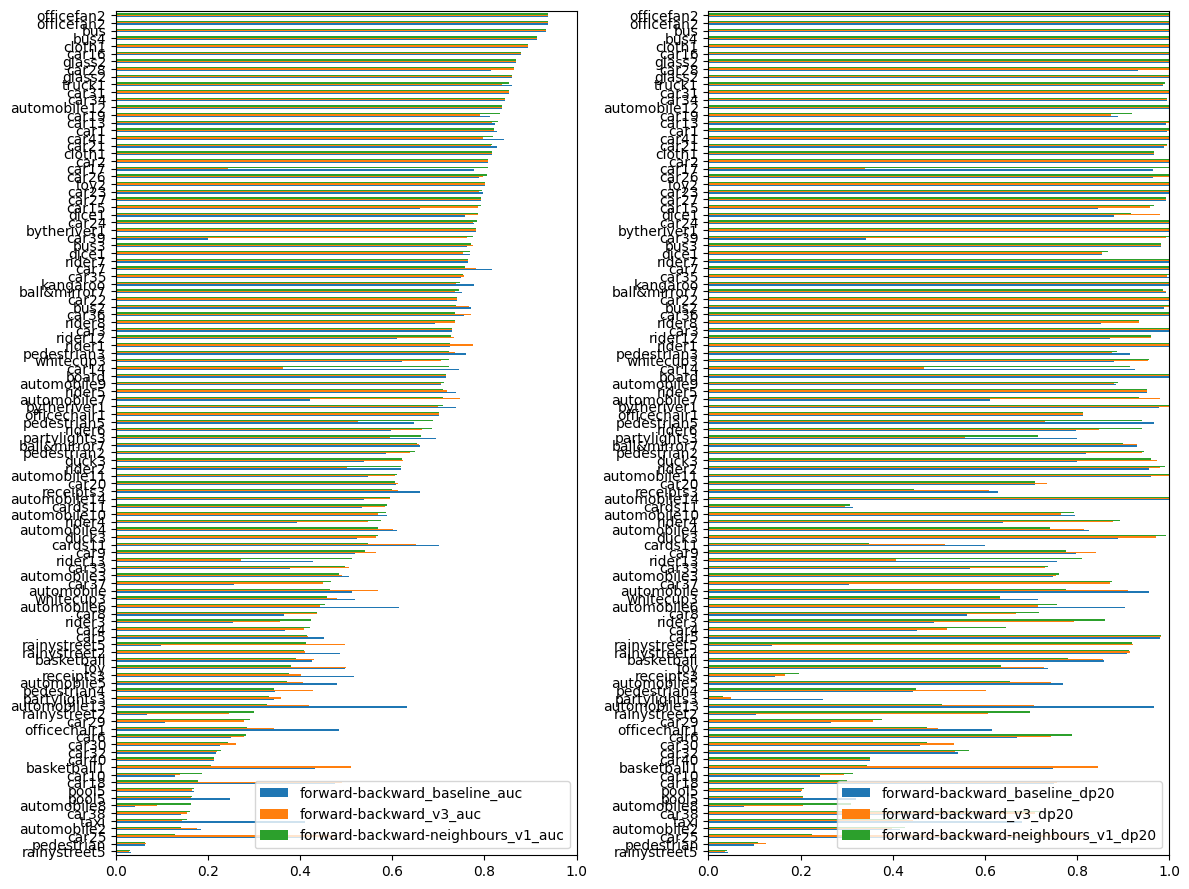

In [8]:
_, summary = eval_results_v2(
    dataset,
    ["forward-backward_baseline", "forward-backward_v3","forward-backward-neighbours_v1"],
    plot=True,
)
#     sequence_ids=test_scenes)
summary

metric,model,mean AUC,mean DP20
0,forward-backward-neighbours_v1,0.627657,0.841613
2,forward-backward_v3,0.605431,0.820590
1,forward-backward_baseline,0.599976,0.805493


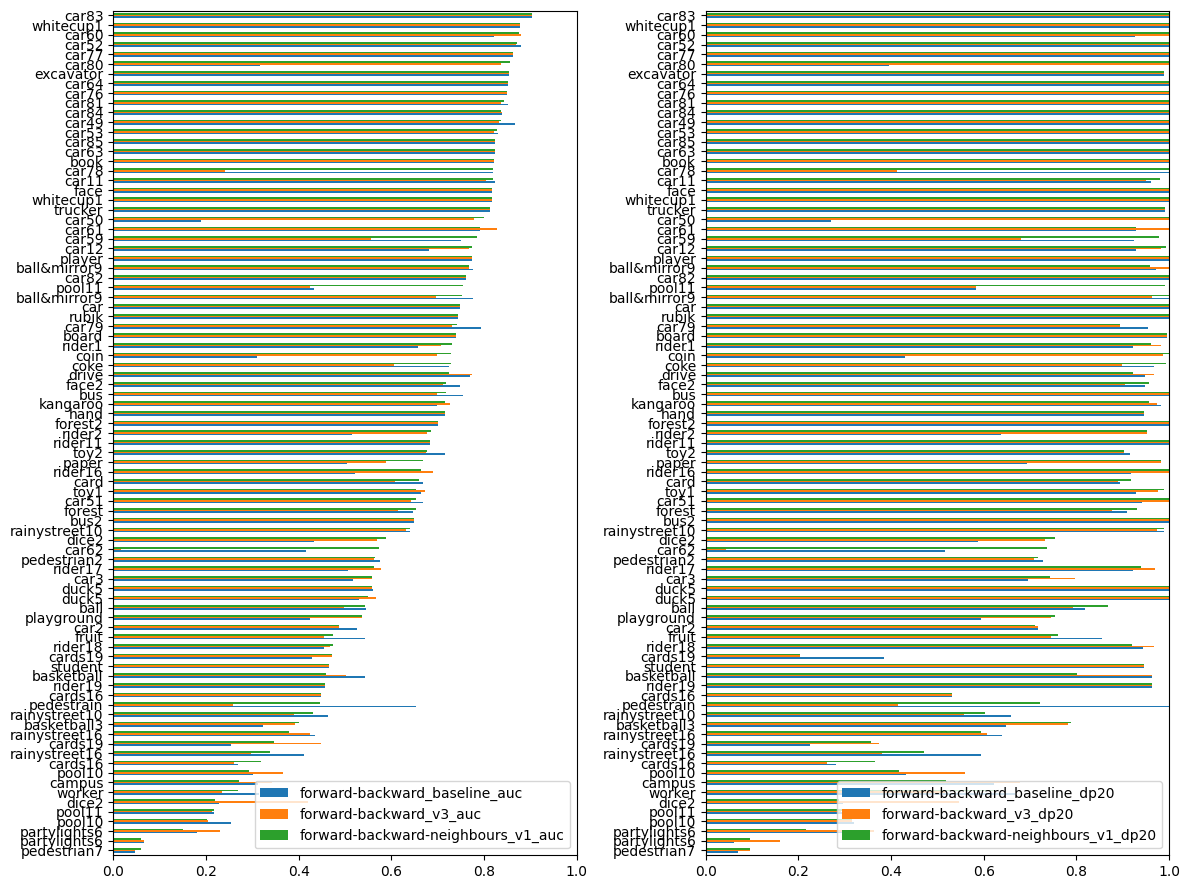

In [9]:
_, summary = eval_results_v2(
    val_dataset,
    ["forward-backward_baseline", "forward-backward_v3","forward-backward-neighbours_v1"],
    plot=True,
)
#     sequence_ids=test_scenes)
summary